In [225]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import random
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
import torch.nn.functional as F
import copy

#### Firstly, define some common functions to make things easier in the future

In [242]:
# pyTorch neural network class

class MyPytorchNetwork(nn.Module):
    def __init__(self, layers, activation):
        super(MyPytorchNetwork, self).__init__()
        self.activation = activation
        self.fc_layers = nn.ModuleList([nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])

    def forward(self, x):
        x = torch.flatten(x, 1)

        # TODO: I'm using relus everywhere for now, we need to change it to be adjustable
        for layer in self.fc_layers[:-1]:
            if self.activation == 'linear':
                x = layer(x)
            elif self.activation == 'relu':
                x = F.relu(layer(x))
            elif self.activation == 'sigmoid':
                x = torch.sigmoid(layer(x))
            elif self.activation == 'tanh':
                x = torch.tanh(layer(x))
            else:
                raise ValueError(f"Activation funtion {self.activation} is invalid")

        # Always sigmoid on the last lauer
        return torch.sigmoid(self.fc_layers[-1](x))


def train_torch_network(network: MyPytorchNetwork, dataset, max_epochs, batch_size, train_ratio=0.8,
                        learning_rate=0.001, momentum=0.9, silent=False):
    loss_fn = torch.nn.BCELoss()
    # TODO: think of making the learning rate adaptive here, e.g. by using pytorch LR scheduler
    optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
    split_index = int(dataset.shape[0] * train_ratio)
    train, validation = dataset[:split_index, :], torch.from_numpy(dataset[split_index:, :])

    best_validation_loss = float("inf")
    best_network = copy.deepcopy(network)

    for epoch in range(max_epochs):
        np.random.shuffle(train)
        torch_train = torch.from_numpy(train)
        batch_start_idx = 0

        batches_loss = []
        # This way we skip last samples if there are less than batch_size of them
        while batch_start_idx + batch_size <= torch_train.shape[0]:
            optimizer.zero_grad()
            outputs = network(torch_train[batch_start_idx:batch_start_idx + batch_size, :-1])
            loss = loss_fn(torch.flatten(outputs), torch_train[batch_start_idx:batch_start_idx + batch_size, -1])
            batches_loss.append(loss.item())

            loss.backward()

            optimizer.step()
            batch_start_idx += batch_size

        # Now, check the loss on validation dataset
        validation_output = torch.flatten(network(validation[:, :-1]))
        validation_loss = loss_fn(validation_output, validation[:, -1])
        # print(f"{validation_loss=}")

        if validation_loss < best_validation_loss:
            best_validation_loss = validation_loss
            best_network = copy.deepcopy(network)


        if not silent:
            print(
                f"Epoch: {epoch}. \nLoss on training: {np.mean(batches_loss)} \nLoss on validation: {validation_loss} \n##########")

    return best_network


In [248]:
def run_svm(svm_parameters, train_dataset, test_inputs) -> np.array:
    svc = SVC(**svm_parameters)
    svc.fit(train_dataset[:, :-1], train_dataset[:, -1])
    return svc.predict(test_inputs)


def run_linear_regression(train_dataset, test_inputs) -> np.array:
    """
    Train a linear regression on train_inputs, and predict data for test_inputs
    """
    reg = LinearRegression().fit(train_dataset[:, :-1], train_dataset[:, -1])
    prediction = reg.predict(test_inputs)
    prediction[prediction > 0.5] = 1
    prediction[prediction != 1] = 0
    return prediction


def run_pytorch_network(network_parameters, lr, epochs, train_dataset, test_inputs, silent=True) -> np.array:
    """
    Train a pytorch network and predict outputs for test_inputs
    """
    torch.manual_seed(0)
    random.seed(42)
    np.random.seed(42)
    network = MyPytorchNetwork(*network_parameters)
    network = train_torch_network(network, train_dataset, epochs, 10, learning_rate=lr, silent=silent, momentum=0.9,
                        train_ratio=0.8)
    prediction = network(torch.from_numpy(test_inputs)).detach().numpy().flatten()
    prediction[prediction > 0.5] = 1
    prediction[prediction != 1] = 0
    return prediction

In [87]:
def classification_error(real_values, predictions):
    return 100 * np.sum(np.abs(real_values - predictions)) / real_values.shape[0]


def n_folds(n, train_data, model, silent=True):
    # Maybe this is not the best place to set the seed, but this case each run of the function is predictable
    np.random.seed(42)
    np.random.shuffle(train_data)
    split_indices = [int(i * train_data.shape[0] / n) for i in range(n + 1)]
    errors = []

    for i in range(n):
        split_validation = train_data[split_indices[i]:split_indices[i + 1], :]
        split_training = np.vstack((train_data[:split_indices[i], :], train_data[split_indices[i + 1]:, :]))
        split_pred = model(split_training, split_validation[:, :-1])
        error = classification_error(split_pred, split_validation[:, -1])
        if not silent:
            print(f"Error on one validation split: {error=}")
        errors.append(error)
    return np.mean(error)


### Trying with "ring" dataset

In [90]:
def plot_ring_pred(data, pred):
    plt.scatter(data[pred == 0, 0], data[pred == 0, 1], color='blue')
    plt.scatter(data[pred == 1, 0], data[pred == 1, 1], color='red')
    plt.axis('equal')

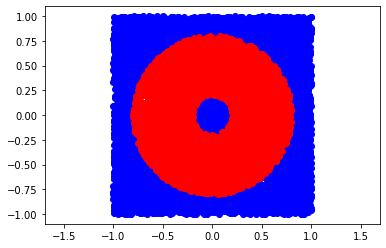

In [91]:
# Firstly, try with the separable one
ring_sep = np.genfromtxt("A2-ring/A2-ring-separable.txt", dtype=np.float32, delimiter="\t")
ring_merged = np.genfromtxt("A2-ring/A2-ring-merged.txt", dtype=np.float32, delimiter="\t")
ring_test = np.genfromtxt("A2-ring/A2-ring-test.txt", dtype=np.float32, delimiter="\t")
plot_ring_pred(ring_sep[:, :2], ring_sep[:, 2])

In [96]:
n_folds(5, ring_sep, lambda *params: run_svm({"kernel": "linear"}, *params), silent=False)

Error on one validation split: error=48.9
Error on one validation split: error=48.35
Error on one validation split: error=48.3
Error on one validation split: error=47.95
Error on one validation split: error=46.35


46.35

In [99]:
# Plotting the data
pred = run_svm({"kernel": "linear"}, ring_sep, ring_test[:, :-1])

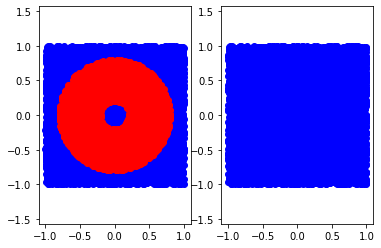

In [100]:
plt.subplot(1, 2, 1)
plot_ring_pred(ring_test[:, :2], ring_test[:, 2])
plt.subplot(1, 2, 2)
plot_ring_pred(ring_test[:, :2], pred)

As predicted, an SVM with linear kernel cannot properly separate such data

Error on one validation split: error=0.5
Error on one validation split: error=0.55
Error on one validation split: error=0.25
Error on one validation split: error=0.5
Error on one validation split: error=0.55
Error: 0.31%


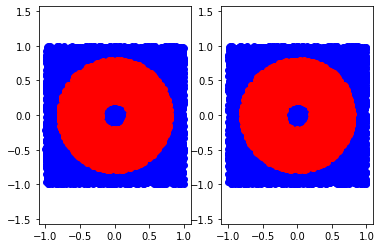

In [104]:
n_folds(5, ring_sep, lambda *params: run_svm({"kernel": "rbf", "C": 100, "gamma": 4}, *params), silent=False)
pred = run_svm({"kernel": "rbf", "C": 100, "gamma": 4}, ring_sep, ring_test[:, :-1])
plt.subplot(1, 2, 1)
plot_ring_pred(ring_test[:, :2], ring_test[:, 2])
plt.subplot(1, 2, 2)
plot_ring_pred(ring_test[:, :2], pred)
print(f"Error: {classification_error(pred, ring_test[:, -1])}%")

On the other hand, when data is linearly separable, a radial kernel works perfectly with pretty large gamma and large C. However, these parameters need to be tuned better when dealing with merged data. As we can see in the following section, during cross validation the error is pretty large, as the data is tightly "merged" into each other. However, the test set is a subset of linearly separable one, and on it only 2.08% of samples are misclassified

Error on one validation split: error=21.75
Error on one validation split: error=22.05
Error on one validation split: error=21.05
Error on one validation split: error=21.4
Error on one validation split: error=23.3
Error: 2.08%


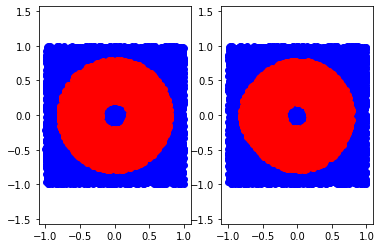

In [146]:
svm_params = {"kernel": "rbf", "C": 1, "gamma": 2}
n_folds(5, ring_merged, lambda *args: run_svm(svm_params, *args), silent=False)
pred = run_svm(svm_params, ring_merged, ring_test[:, :-1])
plt.subplot(1, 2, 1)
plot_ring_pred(ring_test[:, :2], ring_test[:, 2])
plt.subplot(1, 2, 2)
plot_ring_pred(ring_test[:, :2], pred)
print(f"Error: {classification_error(pred, ring_test[:, -1])}%")

#### As expected, linear regression cannot classify the data, so the best it can do is to classify all the elements into more represented class

Error on one validation split: error=45.35
Error on one validation split: error=45.55
Error on one validation split: error=45.2
Error on one validation split: error=43.15
Error on one validation split: error=45.0
Error on one validation split: error=50.3
Error on one validation split: error=56.35
Error on one validation split: error=48.2
Error on one validation split: error=49.25
Error on one validation split: error=48.8
Error: 46.67%


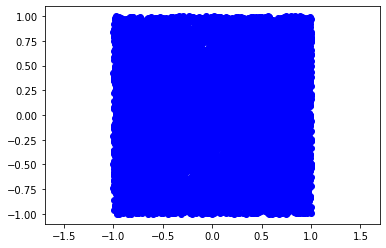

In [245]:
n_folds(5, ring_merged, run_linear_regression, silent=False)
n_folds(5, ring_sep, run_linear_regression, silent=False)
pred = run_linear_regression(ring_merged, ring_test[:, :-1])
plot_ring_pred(ring_test[:, :2], pred)
print(f"Error: {classification_error(pred, ring_test[:, -1])}%")

When trying to train a neural network, I was experimenting with many parameters and found ones that give a good enough result. I use binary cross-entropy loss for training and 2 large hidden layers with tanh activation. Here, I am validating using N-folds and then train a network on full input data

Error on one validation split: error=2.55
Error on one validation split: error=3.2
Error on one validation split: error=2.5
Error on one validation split: error=2.25
Error on one validation split: error=2.9
Error: 1.47%


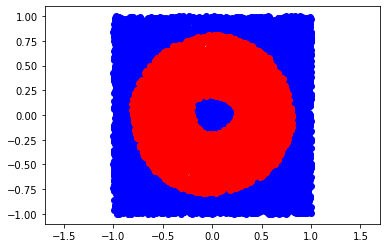

In [246]:
nn_params = [[2, 16, 15, 1], 'tanh']

n_folds(5, ring_sep, lambda *args: run_pytorch_network(nn_params, 0.006, 30, *args), silent=False)
pred = run_pytorch_network(nn_params, 0.006, 30, ring_sep.copy(), ring_test[:, :-1])
plot_ring_pred(ring_test[:, :2], pred)
print(f"Error: {classification_error(pred, ring_test[:, -1])}%")

On not linearly separable data the network pretty quickly converges to a point where both training and validation losses don't change much. Maybe with some parameters the performance would be better, but even now the error is 5%, which is not much

Error on one validation split: error=19.9
Error on one validation split: error=23.4
Error on one validation split: error=23.85
Error on one validation split: error=20.5
Error on one validation split: error=22.2
Epoch: 0. 
Loss on training: 0.6488407787680626 
Loss on validation: 0.5688090324401855 
##########
Epoch: 1. 
Loss on training: 0.5367344590649009 
Loss on validation: 0.5721774101257324 
##########
Epoch: 2. 
Loss on training: 0.5250835539773107 
Loss on validation: 0.5578290820121765 
##########
Epoch: 3. 
Loss on training: 0.5259814995341003 
Loss on validation: 0.5486482977867126 
##########
Epoch: 4. 
Loss on training: 0.5183635067753494 
Loss on validation: 0.5375968813896179 
##########
Epoch: 5. 
Loss on training: 0.5145256756804883 
Loss on validation: 0.550197184085846 
##########
Epoch: 6. 
Loss on training: 0.5135133853182197 
Loss on validation: 0.544791042804718 
##########
Epoch: 7. 
Loss on training: 0.5072705997154117 
Loss on validation: 0.5361325740814209 
##

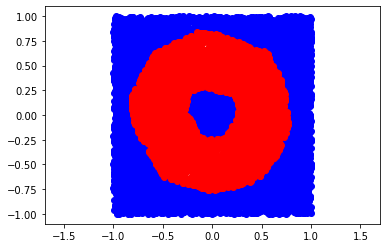

In [249]:
nn_params = [[2, 16, 15, 1], 'relu']

n_folds(5, ring_merged, lambda *args: run_pytorch_network(nn_params, 0.01, 20, *args), silent=False)
pred = run_pytorch_network(nn_params, 0.01, 20, ring_merged.copy(), ring_test[:, :-1], silent=False)
plot_ring_pred(ring_test[:, :2], pred)
print(f"Error: {classification_error(pred, ring_test[:, -1])}%")